Importing packages

In [378]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt

Pulling data from API

In [379]:
url = "https://apisidra.ibge.gov.br/values//t/9542/p/2022/v/950/c59/allxt/c2/allxt/c86/allxt/c287/93086,93087,2999,9482,9483,9484/n3/all/h/y/f/n"
r = requests.get(url)
if r.ok:
    data = pd.read_json(StringIO(r.text))
else:
    print('Tente novamente. Status code:', r.status_code)

Cleaning data

In [380]:
data = data.rename(columns=data.iloc[0]).drop(data.index[0])
data = data.reset_index(drop=True)
data = data.drop(columns=['Nível Territorial','Unidade de Medida','Variável', 'Ano'])
negativos = len(data[data['Valor']=='-'])
print(f'Valores negativos:', negativos)
print('---------Cleaning-------')
data['Valor'] = data['Valor'].replace({'-': np.nan})
data['Valor'] = pd.to_numeric(data['Valor'])
data = data.dropna(subset=['Valor'])
print(data.isnull().sum())
print('-------dtypes-----------')
print(data.dtypes)
data.loc[:, 'Idade'] = data['Idade'].str.replace(r'(\d+)\s*a\s*(\d+)\s*anos', r'\1-\2', regex=True)

Valores negativos: 15
---------Cleaning-------
Valor                   0
Alfabetização           0
Sexo                    0
Cor ou raça             0
Idade                   0
Unidade da Federação    0
dtype: int64
-------dtypes-----------
Valor                   float64
Alfabetização            object
Sexo                     object
Cor ou raça              object
Idade                    object
Unidade da Federação     object
dtype: object


In [381]:
lista = data.columns[1:].tolist()
for coluna in lista:
    print(f'Coluna {coluna}:')
    print(data[coluna].unique())

Coluna Alfabetização:
['Alfabetizadas' 'Não alfabetizadas']
Coluna Sexo:
['Homens' 'Mulheres']
Coluna Cor ou raça:
['Branca' 'Preta' 'Amarela' 'Parda' 'Indígena']
Coluna Idade:
['15-19' '20-24' '25-34' '35-44' '45-54' '55-64']
Coluna Unidade da Federação:
['Rondônia' 'Acre' 'Amazonas' 'Roraima' 'Pará' 'Amapá' 'Tocantins'
 'Maranhão' 'Piauí' 'Ceará' 'Rio Grande do Norte' 'Paraíba' 'Pernambuco'
 'Alagoas' 'Sergipe' 'Bahia' 'Minas Gerais' 'Espírito Santo'
 'Rio de Janeiro' 'São Paulo' 'Paraná' 'Santa Catarina'
 'Rio Grande do Sul' 'Mato Grosso do Sul' 'Mato Grosso' 'Goiás'
 'Distrito Federal']


In [382]:
uf = {
    'Rondônia': 'RO',
    'Acre': 'AC',
    'Amazonas': 'AM',
    'Roraima': 'RR',
    'Pará': 'PA',
    'Amapá': 'AP',
    'Tocantins': 'TO',
    'Maranhão': 'MA',
    'Piauí': 'PI',
    'Ceará': 'CE',
    'Rio Grande do Norte': 'RN',
    'Paraíba': 'PB',
    'Pernambuco': 'PE',
    'Alagoas': 'AL',
    'Sergipe': 'SE',
    'Bahia': 'BA',
    'Minas Gerais': 'MG',
    'Espírito Santo': 'ES',
    'Rio de Janeiro': 'RJ',
    'São Paulo': 'SP',
    'Paraná': 'PR',
    'Santa Catarina': 'SC',
    'Rio Grande do Sul': 'RS',
    'Mato Grosso do Sul': 'MS',
    'Mato Grosso': 'MT',
    'Goiás': 'GO',
    'Distrito Federal': 'DF'
}

cor = {'Branca':'White','Preta':'Black','Amarela':'Asian','Parda':'Latino','Indígena':'Indigenous'}
genero = {'Homens':'Male','Mulheres':'Female'}
alfabetizacao = {'Alfabetizadas':'Yes','Não alfabetizadas':'No'}

data.loc[:, 'Cor ou raça'] = data['Cor ou raça'].replace(cor)
data.loc[:, 'Alfabetização'] = data['Alfabetização'].replace(alfabetizacao)
data.loc[:, 'Unidade da Federação'] = data['Unidade da Federação'].replace(uf)
data.loc[:, 'Sexo'] = data['Sexo'].replace(genero)

data = data.rename(columns={"Valor": "Population", 'Alfabetização': 'Literate', 'Cor ou raça': 'Race', 'Idade': 'Age-Group', 'Unidade da Federação': 'State', 'Sexo': 'Gender'})

In [383]:
# data.to_csv("/home/satire/PycharmProjects/Statistics/csv/data.csv", index=False)
df = data.copy()

In [384]:
table_race = pd.pivot_table(df, values='Population', index=['Literate', 'Gender'],
                       columns=['Race'], aggfunc="sum")
table_age = pd.pivot_table(df, values='Population', index=['Literate', 'Gender'],
                       columns=['Age-Group'], aggfunc="sum")
gender_age = pd.pivot_table(df, values='Population', index=['Gender'],
                              columns=['Age-Group'], aggfunc='sum').reset_index()

In [385]:
columns_age = table_age.columns[0:].tolist()
for col in columns_age:
    table_age[col] = (table_age[col] / table_age[col].sum()) * 100

In [386]:
table_age = table_age.style. \
    background_gradient(cmap='Reds', axis=None). \
    set_table_styles(
    [{'selector':'th,td,tr', 'props': [('border-style', 'solid'), ('border-width', '2px')]}]
)
table_age

In [387]:
columns_race = table_race.columns[0:].tolist()
for col in columns_race:
    table_race[col] = (table_race[col] / table_race[col].sum()) * 100

In [388]:
table_race = table_race.style. \
    background_gradient(cmap='Reds', axis=None). \
    set_table_styles(
    [{'selector':'th,td,tr', 'props': [('border-style', 'solid'), ('border-width', '2px')]}]
)
table_race

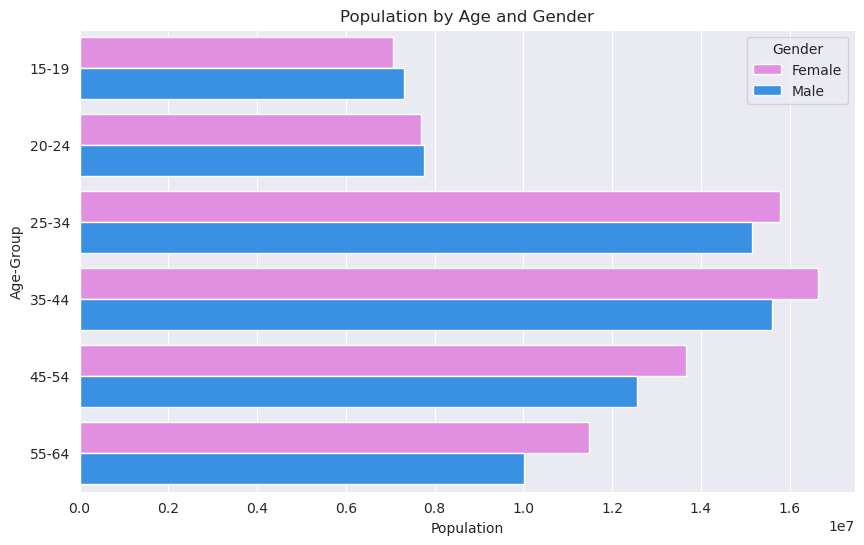

In [389]:
gender_age = pd.melt(gender_age, id_vars=['Gender'], var_name='Age-Group', value_name='Population')
plt.figure(figsize=(10, 6))
sns.barplot(data=gender_age, x='Population', y='Age-Group', hue='Gender', palette={'Male': '#1E90FF', 'Female': '#EE82EE'})
plt.title('Population by Age and Gender')
plt.show()

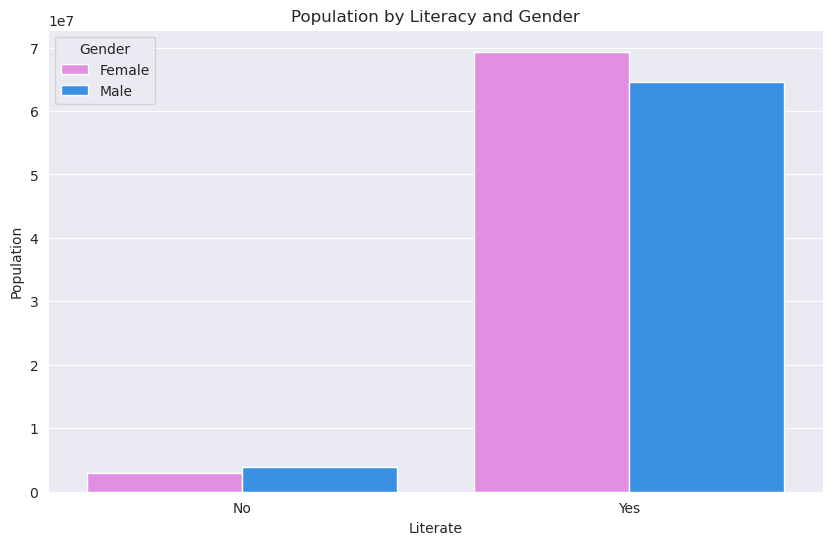

In [390]:
gender_literacy = df.groupby(['Gender', 'Literate']).agg(
    Population=('Population', 'sum')).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=gender_literacy, x="Literate", y="Population", hue="Gender", palette={'Male': '#1E90FF', 'Female': '#EE82EE'})
plt.title('Population by Literacy and Gender')
plt.show()

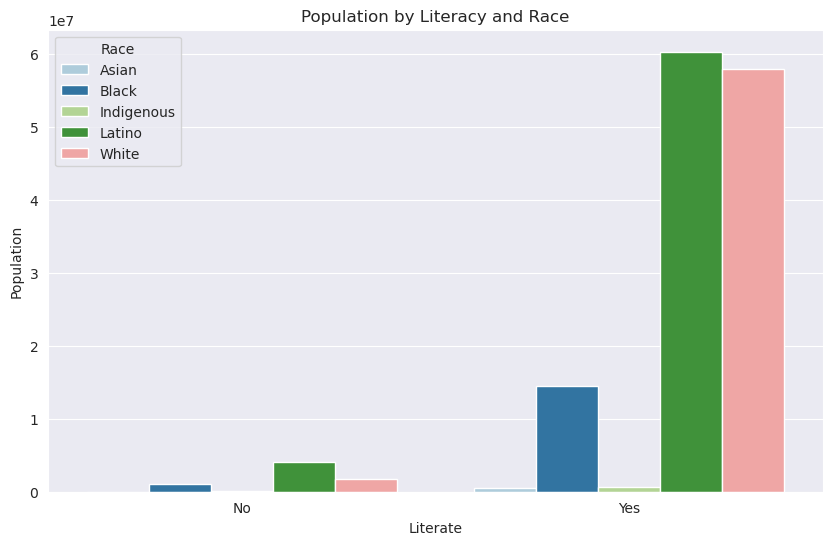

In [391]:
race_literacy = df.groupby(['Literate', 'Race']).agg(
    Population=('Population', 'sum')
)
plt.figure(figsize=(10, 6))
sns.barplot(data=race_literacy, x="Literate", y="Population", hue="Race", palette='Paired')
plt.title('Population by Literacy and Race')
plt.show()

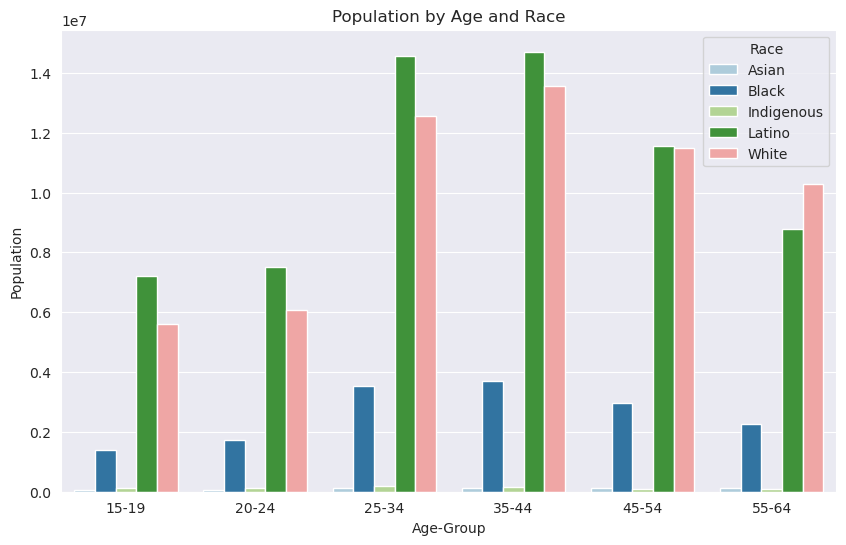

In [392]:
race_age = df.groupby(['Age-Group', 'Race']).agg(
    Population=('Population', 'sum')
)
plt.figure(figsize=(10, 6))
sns.barplot(data=race_age, x="Age-Group", y="Population", hue="Race", palette='Paired')
plt.title('Population by Age and Race')
plt.show()

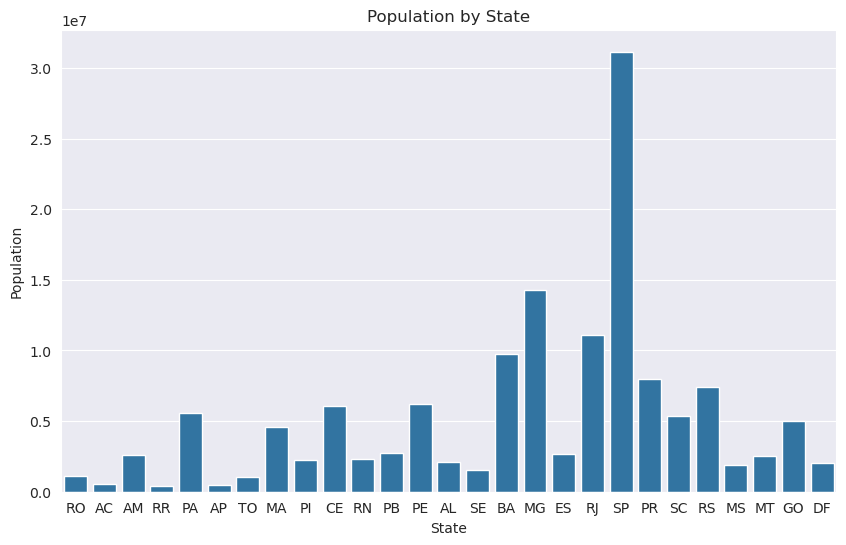

In [393]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="State", y="Population", estimator="sum", errorbar=None)
plt.title('Population by State')
plt.show()